In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Knowledge distillation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# First: Download datasets separately to identify if this is the bottleneck
print("Downloading datasets...")
train_dataset = datasets.MNIST(root="./data", train=True, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, download=True)
print("Datasets downloaded successfully!")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model (ResNet-50)
print("Loading teacher model...")
teacher_model = models.resnet50(pretrained=False)
num_classes = 10
teacher_model.fc = nn.Linear(2048, num_classes)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth", map_location=device))
teacher_model.to(device)
teacher_model.eval()  # Freeze teacher model
print("Teacher model loaded successfully!")

# Initialize student model (ResNet-18) from scratch
print("Initializing student model from scratch...")
student_soft_target = models.resnet18(pretrained=False)
student_soft_target.fc = nn.Linear(512, num_classes)
student_soft_target.to(device)
print("Student model initialized!")

# Distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, T=3.0, alpha=0.5):
        super().__init__()
        self.T = T
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction="batchmean")
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_loss = self.kl_div(
            nn.functional.log_softmax(student_logits / self.T, dim=1),
            nn.functional.softmax(teacher_logits / self.T, dim=1)
        ) * (self.T ** 2)
        hard_loss = self.ce_loss(student_logits, labels)
        return self.alpha * hard_loss + (1 - self.alpha) * soft_loss

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

print("Creating data loaders...")
# Now load with transform (data already downloaded)
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
print("Data loaders created!")

# Training setup
optimizer = optim.Adam(student_soft_target.parameters(), lr=0.001)
criterion = DistillationLoss(T=3.0, alpha=0.5)

# Training loop
print("Starting training...")
for epoch in range(10):
    student_soft_target.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        student_outputs = student_soft_target(images)
        loss = criterion(student_outputs, teacher_outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    student_soft_target.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_soft_target(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")

# Save the trained student model
torch.save(student_soft_target.state_dict(), "student_model_soft_target_mnist.pth")
print("Training complete! Student model saved as 'student_model_mnist.pth'!")


Datasets downloaded successfully!
Using device: cuda
Loading teacher model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Teacher model loaded successfully!
Initializing student model from scratch...
Student model initialized!
Creating data loaders...
Data loaders created!
Starting training...
Epoch [1/10], Loss: 0.6916, Train Acc: 92.52%
Validation Accuracy: 97.54%
Epoch [2/10], Loss: 0.6439, Train Acc: 95.52%
Validation Accuracy: 95.15%
Epoch [3/10], Loss: 0.6354, Train Acc: 95.96%
Validation Accuracy: 94.36%
Epoch [4/10], Loss: 0.6306, Train Acc: 96.23%
Validation Accuracy: 98.32%
Epoch [5/10], Loss: 0.6272, Train Acc: 96.50%
Validation Accuracy: 96.77%
Epoch [6/10], Loss: 0.6256, Train Acc: 96.54%
Validation Accuracy: 96.53%
Epoch [7/10], Loss: 0.6222, Train Acc: 96.77%
Validation Accuracy: 95.62%
Epoch [8/10], Loss: 0.6211, Train Acc: 96.80%
Validation Accuracy: 97.75%
Epoch [9/10], Loss: 0.6187, Train Acc: 96.91%
Validation Accuracy: 97.67%
Epoch [10/10], Loss: 0.6178, Train Acc: 96.98%
Validation Accuracy: 94.31%
Training complete! Student model saved as 'student_model_mnist.pth'!


Accuracy

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

# Define transformations for the student model
transform_student = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load test dataset for student model
test_dataset_student = datasets.MNIST(root="./data", train=False, transform=transform_student, download=False)
test_loader_student = DataLoader(test_dataset_student, batch_size=64, shuffle=False, num_workers=2)

# Function to evaluate student model
def evaluate_student(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Student Model Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the Student Model
student_accuracy = evaluate_student(student, test_loader_student, device)


Student Model Accuracy: 95.07%


### Evaluation metrics

Compression Ratio

In [ ]:
def get_model_params(model):
    # Get the number of parameters in the model
    return sum(p.numel() for p in model.parameters())

# Calculate number of parameters in teacher and student models
teacher_params = get_model_params(teacher_model)
student_params = get_model_params(student)

# Calculate compression ratio
compression_ratio = student_params / teacher_params
print(f"Compression Ratio (Student/Teacher): {compression_ratio:.4f}")
print(f"Teacher Model Parameters: {teacher_params}")
print(f"Student Model Parameters: {student_params}")


Compression Ratio (Student/Teacher): 0.4752
Teacher Model Parameters: 23528522
Student Model Parameters: 11181642


Inference Time

In [ ]:
import torch
import time
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Teacher Model (ResNet-50)
teacher_model = models.resnet50(weights=None)
teacher_model.fc = torch.nn.Linear(2048, 10)  # Adjust output layer for MNIST
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth", map_location=device))
teacher_model.to(device).eval()

# Load Student Model (ResNet-18)
student_model = models.resnet18(weights=None)
student_model.fc = torch.nn.Linear(512, 10)  # Adjust output layer for MNIST
student_model.to(device).eval()

# Data transformation (MNIST to ResNet format)
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert grayscale to 3 channels
    transforms.Resize(224),   # Resize for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load MNIST dataset correctly
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# Get a single test image
test_image, _ = next(iter(test_loader))
test_image = test_image.to(device)  # Move to GPU if available

# Function to measure inference time
def measure_inference_time(model, input_tensor, num_runs=100):
    model.eval()

    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)

    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Convert to milliseconds

# Measure inference time
teacher_time = measure_inference_time(teacher_model, test_image)
student_time = measure_inference_time(student_model, test_image)

print(f"Teacher Model (ResNet-50) Inference Time: {teacher_time:.3f} ms")
print(f"Student Model (ResNet-18) Inference Time: {student_time:.3f} ms")
print(f"Speedup Factor: {teacher_time / student_time:.2f}x Faster")


Teacher Model (ResNet-50) Inference Time: 7.300 ms
Student Model (ResNet-18) Inference Time: 2.888 ms
Speedup Factor: 2.53x Faster


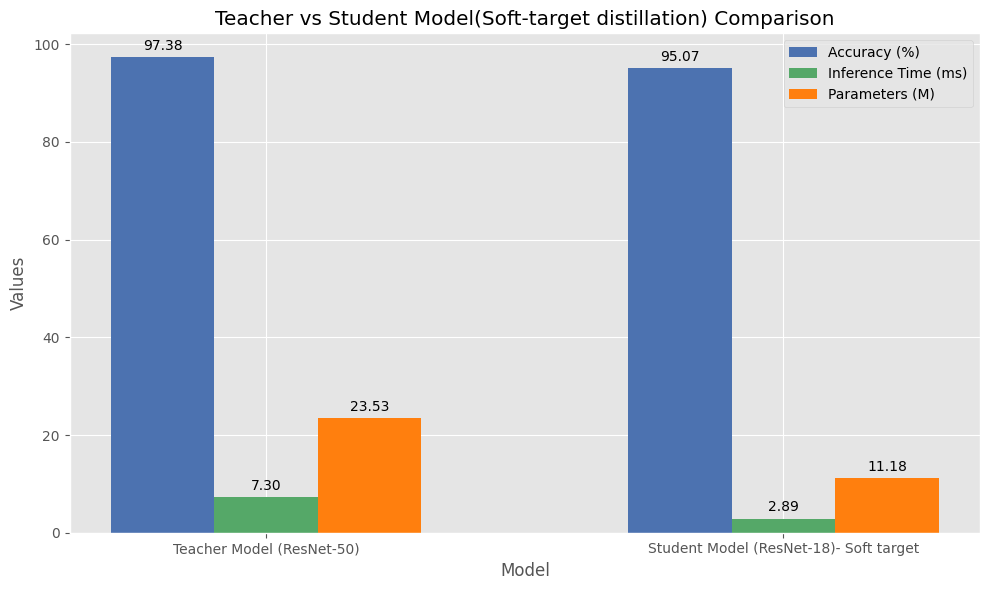

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Teacher Model (ResNet-50)', 'Student Model (ResNet-18)- Soft target']
accuracy = [97.38, 95.07]
inference_time = [7.300, 2.888]  # In milliseconds
params = [23528522, 11181642]  # Number of parameters

# Convert parameter counts to millions
params_millions = [p / 1e6 for p in params]

# Set up positions for each set of bars
x = np.arange(len(labels))  # The label locations
width = 0.2  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each metric
bars1 = ax.bar(x - width, accuracy, width, label='Accuracy (%)', color='#4c72b0')
bars2 = ax.bar(x, inference_time, width, label='Inference Time (ms)', color='#55a868')
bars3 = ax.bar(x + width, params_millions, width, label='Parameters (M)', color='#ff7f0e')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Values')
ax.set_title('Teacher vs Student Model(Soft-target distillation) Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add data labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Show the plot
plt.tight_layout()
plt.show()


## ATTENTION TRANSFER

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Attention Map Extraction with adaptive pooling to handle channel mismatch
def extract_attention_map(features):
    # Global average pooling + squared activations
    return F.adaptive_avg_pool2d(features.pow(2), (1, 1)).squeeze()

# Improved Attention Transfer Loss with channel adaptation
class AttentionTransferLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, T=4.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.ce_loss = nn.CrossEntropyLoss()

        # Adaptors to match channel dimensions
        self.adaptor_l1 = nn.Conv2d(64, 256, kernel_size=1).to(device)  # For layer1
        self.adaptor_l2 = nn.Conv2d(128, 512, kernel_size=1).to(device) # For layer2

    def attention_loss(self, student_att, teacher_att):
        # Normalize attention maps
        student_att = student_att / (student_att.norm(p=2, dim=1, keepdim=True) + 1e-8)
        teacher_att = teacher_att / (teacher_att.norm(p=2, dim=1, keepdim=True) + 1e-8)
        # L2 distance between normalized attention maps
        return (student_att - teacher_att).pow(2).sum(dim=1).mean()

    def forward(self, student_feats_l1, teacher_feats_l1,
               student_feats_l2, teacher_feats_l2,
               student_logits, teacher_logits, labels):
        # Adapt student features to match teacher dimensions
        student_feats_l1 = self.adaptor_l1(student_feats_l1)
        student_feats_l2 = self.adaptor_l2(student_feats_l2)

        # Calculate attention losses
        att_loss_l1 = self.attention_loss(
            extract_attention_map(student_feats_l1),
            extract_attention_map(teacher_feats_l1)
        )
        att_loss_l2 = self.attention_loss(
            extract_attention_map(student_feats_l2),
            extract_attention_map(teacher_feats_l2)
        )

        # Cross-Entropy Loss
        ce_loss = self.ce_loss(student_logits, labels)

        # Knowledge Distillation Loss
        soft_loss = F.kl_div(
            F.log_softmax(student_logits/self.T, dim=1),
            F.softmax(teacher_logits/self.T, dim=1),
            reduction='batchmean'
        ) * (self.T ** 2)

        # Combined loss (adjust weights as needed)
        total_loss = (self.alpha * att_loss_l1 +
                     self.beta * att_loss_l2 +
                     0.3 * ce_loss +
                     0.2 * soft_loss)

        return {
            "total": total_loss,
            "att_l1": att_loss_l1,
            "att_l2": att_loss_l2,
            "ce": ce_loss,
            "distill": soft_loss
        }

# Load teacher model (ResNet-50)
teacher_model = models.resnet50(weights=None)
num_classes = 10
teacher_model.fc = nn.Linear(2048, num_classes)
teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_mnist.pth", map_location=device))
teacher_model.to(device)
teacher_model.eval()

# Initialize student model (ResNet-18)
student = models.resnet18(weights=None)
student.fc = nn.Linear(512, num_classes)
student.to(device)

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data loading
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize optimizer and loss function
optimizer = optim.Adam(student.parameters(), lr=0.001)
criterion = AttentionTransferLoss(alpha=1.0, beta=1.0, T=4.0)

# Training loop
for epoch in range(10):
    student.train()
    total_stats = {"total": 0.0, "att_l1": 0.0, "att_l2": 0.0, "ce": 0.0, "distill": 0.0}
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass through teacher model
        with torch.no_grad():
            x = teacher_model.conv1(images)
            x = teacher_model.bn1(x)
            x = teacher_model.relu(x)
            x = teacher_model.maxpool(x)

            teacher_feats_l1 = teacher_model.layer1(x)
            teacher_feats_l2 = teacher_model.layer2(teacher_feats_l1)
            teacher_outputs = teacher_model(images)

        # Forward pass through student model
        x = student.conv1(images)
        x = student.bn1(x)
        x = student.relu(x)
        x = student.maxpool(x)

        student_feats_l1 = student.layer1(x)
        student_feats_l2 = student.layer2(student_feats_l1)
        student_outputs = student(images)

        # Compute losses
        losses = criterion(
            student_feats_l1, teacher_feats_l1,
            student_feats_l2, teacher_feats_l2,
            student_outputs, teacher_outputs,
            labels
        )

        # Backpropagation
        optimizer.zero_grad()
        losses["total"].backward()
        optimizer.step()

        # Update statistics
        for k in total_stats:
            total_stats[k] += losses[k].item()

        # Calculate accuracy
        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print batch statistics
        if batch_idx % 100 == 0:
            print(f"\nBatch {batch_idx}:")
            print(f"  Total Loss: {losses['total'].item():.4f}")
            print(f"  Attention L1 Loss: {losses['att_l1'].item():.4f}")
            print(f"  Attention L2 Loss: {losses['att_l2'].item():.4f}")
            print(f"  CE Loss: {losses['ce'].item():.4f}")
            print(f"  Distill Loss: {losses['distill'].item():.4f}")

    # Epoch statistics
    train_acc = 100. * correct / total
    avg_losses = {k: v/len(train_loader) for k, v in total_stats.items()}

    print(f"\nEpoch [{epoch+1}/10]")
    print(f"  Avg Total Loss: {avg_losses['total']:.4f}")
    print(f"  Avg Att L1 Loss: {avg_losses['att_l1']:.4f}")
    print(f"  Avg Att L2 Loss: {avg_losses['att_l2']:.4f}")
    print(f"  Avg CE Loss: {avg_losses['ce']:.4f}")
    print(f"  Avg Distill Loss: {avg_losses['distill']:.4f}")
    print(f"  Train Accuracy: {train_acc:.2f}%")

    # Validation
    student.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"  Validation Accuracy: {val_acc:.2f}%")
    print("-" * 50)

print("Training complete!")

Using device: cuda

Batch 0:
  Total Loss: 4.0293
  Attention L1 Loss: 1.5015
  Attention L2 Loss: 1.4087
  CE Loss: 2.6656
  Distill Loss: 1.5969

Batch 100:
  Total Loss: 1.0772
  Attention L1 Loss: 0.3847
  Attention L2 Loss: 0.2825
  CE Loss: 0.6151
  Distill Loss: 1.1277

Batch 200:
  Total Loss: 0.9578
  Attention L1 Loss: 0.3250
  Attention L2 Loss: 0.2453
  CE Loss: 0.6224
  Distill Loss: 1.0040

Batch 300:
  Total Loss: 0.8477
  Attention L1 Loss: 0.2996
  Attention L2 Loss: 0.2311
  CE Loss: 0.4612
  Distill Loss: 0.8936

Batch 400:
  Total Loss: 0.8496
  Attention L1 Loss: 0.2930
  Attention L2 Loss: 0.2281
  CE Loss: 0.4211
  Distill Loss: 1.0108

Batch 500:
  Total Loss: 0.8158
  Attention L1 Loss: 0.2888
  Attention L2 Loss: 0.2203
  CE Loss: 0.4111
  Distill Loss: 0.9170

Batch 600:
  Total Loss: 0.9160
  Attention L1 Loss: 0.2851
  Attention L2 Loss: 0.2200
  CE Loss: 0.6929
  Distill Loss: 1.0152

Batch 700:
  Total Loss: 0.8453
  Attention L1 Loss: 0.2837
  Attention 

In [ ]:
# Test the student model
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update statistics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the student model
test_accuracy = evaluate_model(student, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Optional: Detailed class-wise accuracy
def evaluate_class_wise(model, test_loader, num_classes=10):
    model.eval()
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print("\nClass-wise Accuracy:")
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f"Class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
        else:
            print(f"Class {i}: No samples")

# Evaluate class-wise accuracy
evaluate_class_wise(student, test_loader)

Final Test Accuracy: 96.91%

Class-wise Accuracy:
Class 0: 99.59%
Class 1: 99.91%
Class 2: 97.67%
Class 3: 98.42%
Class 4: 98.98%
Class 5: 87.56%
Class 6: 96.24%
Class 7: 95.14%
Class 8: 95.69%
Class 9: 98.51%


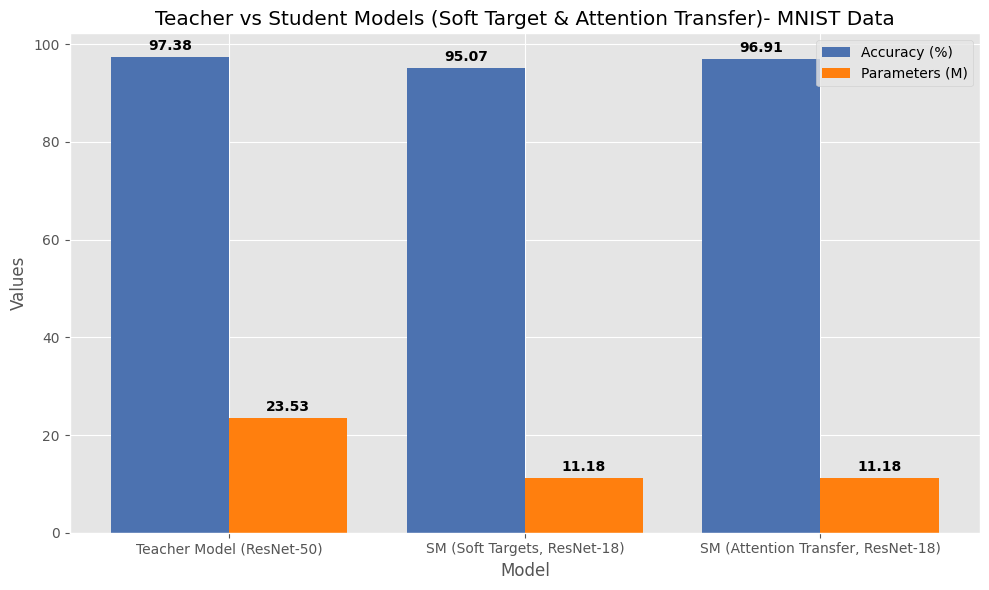

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Teacher Model (ResNet-50)', 'SM (Soft Targets, ResNet-18)', 'SM (Attention Transfer, ResNet-18)']
accuracy = [97.38, 95.07, 96.91]
params = [23528522, 11181642, 11181642]  # Number of parameters
params_millions = [p / 1e6 for p in params]  # Convert to millions

# Set up positions for each set of bars
x = np.arange(len(labels))  # The label locations
width = 0.4  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy (%)', color='#4c72b0')

# Plot model parameters
bars2 = ax.bar(x + width/2, params_millions, width, label='Parameters (M)', color='#ff7f0e')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Values')
ax.set_title('Teacher vs Student Models (Soft Target & Attention Transfer)- MNIST Data')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add data labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(bars1)
add_labels(bars2)

# Show the plot
plt.tight_layout()
plt.show()